# Import Tools 

In [1]:
import numpy as np
import pandas as pd
import random 
from random import randint
import matplotlib.pyplot as plt

# Data Frame

In [2]:
import os 
import pandas as pd
from urllib.request import urlretrieve 

URL = 'https://raw.githubusercontent.com/Castellanos96/SIADS593/main/Items.csv'

def get_data(filename='Items.csv', url=URL, force_download=False):
    if force_download or not os.path.exists(filename):
        urlretrieve(URL, filename)
    return pd.read_csv('Items.csv',index_col=0)

In [3]:
data = get_data()

In [4]:
data.head()

,Item,Weight,Survival Points
0,sleeping bag,15,15
1,rope,3,7
2,pocket knife,2,10
3,flashlight,5,5
4,bottle,9,8


# Requirment Metrics 

In [5]:
#PARAMETER 1: Max weight 30lbs or less 
THRESHOLD = 30

#PARAMETER 2: Initial Population is 20 
SOLUTIONS_PER_POP = 20

#PARAMETER 3: Number of generations
NUM_GENERATIONS = 30

#PARAMETER 4: Number of generations
PARENT_PAIRS = 7 

#PARAMETER 5: CROSSOVER at rate 70%
CROSSOVER_RATES = 0.7

#PARAMETER 6: Mutation Rate = 1%
MUTATION_RATE = 0.01

# Genetic Algorithm Implementation

In [6]:
#Object: Genetic Algorithm 
#Default Paramenters set to match REQUIRED paramenters
#Holds all infomartion and history of generations as attributes 
class Genetic_Algorithm:
    def __init__(self,
                 print_details,
                 threshold =THRESHOLD,
                 population_size =SOLUTIONS_PER_POP,
                 number_of_generations = NUM_GENERATIONS,
                 parent_pairs = PARENT_PAIRS,
                 crossover_rate=CROSSOVER_RATES,
                 mutation_rate=MUTATION_RATE,
                 weight=data['Weight'],
                 value=data['Survival Points'],
                 item_idx=[x for x in range(len(data))]):
        #Print Deatails Atrribute -> Will Display Fitness History, Graph and Last Generation Info
        self.print_details = print_details
        
        #Initialize Attributes to match paramenters, these will not change in value 
        self.threshold = threshold 
        self.population_size = population_size
        self.number_of_generations = number_of_generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.parent_pairs = parent_pairs
        
        #Set Attributes to match weight and values given, used for fitness calculations
        self.weight = weight
        self.value = value
        self.item_idx = item_idx
        
        #Dynamic Attributes Initialized as empty list -> Will constantly change throught generations 
        self.population_matrix = []
        self.fitness_array = [[0] * i for i in range(20)]
        self.parents = []
        self.offsprings = []
        
        #History Attributes -> Used to store generations information 
        self.min_fitness = []
        self.max_fitness = [] 
        self.fitness_avg_history = [] 
        
        
    #Method: Initializes the initial population randomly 
    def create_population(self):
        #Randomly generate a population matrix(row=specimen,col=gene)
        self.population_matrix = [[randint(0, 1) for i in range(len(self.item_idx))] for j in range(self.population_size)]
        
    #Method: Calculates the fitness of a given population matrix
    #Responsibility: Stores results in fitness array 
    def cal_fitness(self):
        
        for i in range(len(self.population_matrix)):
            #compute weight of current items 
            curr_weight = sum([a * b for a, b in zip(self.population_matrix[i],self.weight)])
            #if weight is less than our threshold: compute and save the fitness score 
            if curr_weight <= self.threshold:
                self.fitness_array[i] = sum([a * b for a, b in zip(self.population_matrix[i],self.value)])
            #otherwise: set fitness to zero, rejecting the score in selection 
            else:
                self.fitness_array[i] = 0 
                
    #Method: Selects top 2N fittest parents; where N is number of parent pairs 
    #Responsibility: Stores Selected parents in parents attribute 
    def selection(self):
        #reset parents list to empty 
        self.parents = [] 
        num_parents = int(self.parent_pairs * 2)
        #Create an ascending order list of the INDEX VALUES of the top 2N fittest parents 
        top_parents = sorted(range(len(self.fitness_array)), key=lambda x: self.fitness_array[x])[-num_parents:]
        for item in top_parents:
            #Copy by index the N fittest from population matrix into parents list 
            self.parents.append(self.population_matrix[item])
            
    #Method: Creates offspring from fitness parent pairs 
    #Responsibility: Randomly pairs selected parents 
    #                Creates offpsring from parent pairs at set attribute crossover_rate 
    #                Stores offsprings generated into offsprings attribute 
    def crossover(self):
        #reset offpsring list to empty 
        self.offsprings = [] 
        crossover_rate = int(self.crossover_rate * 10 )
        #randomly shuffle parents 
        r_parents = random.sample(self.parents, len(self.parents))
        #Iterate parents list in randomly shuffled pairs 
        for i,k in zip(r_parents[0::2], r_parents[1::2]):
            #create children from pairs at set crossover rate 
            crossover_index = random.randint(0, 1)
            if crossover_index == 0:
                child = i[:crossover_rate] + k[crossover_rate:]
            else:
                child = k[:crossover_rate] + i[crossover_rate:]
            #save the children into offsprings list 
            self.offsprings.append(child)
            
    #Method: Causes random mutation in children 
    #Responsibility: Iterates throught all offspring 
    #                Randomly chooses 1 gene in sequence 
    #                Randomly generates number 1 through 100: if number is 1 -> Gene chosen is flipped opposite 
    def mutation(self):
        #mutation rate 
        m_rate = int(self.mutation_rate * 100)
        # iterate every child in offspring list
        for child in self.offsprings :
            # and every gene in each child
            for gene in child:
                #has a N% chance of mutation (Defuatly set to 1%)
                r_mutation = random.randint(1,100)
                #if the mutation occurs-> flip current gene to its opposite value 
                if r_mutation == m_rate:
                    if child[gene] == 0:
                        child[gene] = 1
                    else:
                        child[gene] = 0
                #otherwise: we leave it alone 
                else:
                    pass
            
    #Method: Updates the population after offspring process 
    #Responsibility: Kills off weakest from last generation of parents 
    #                Creates population matrix from selected parents and offspring 
    def update_population(self):
        #weakest parent dies 
        self.parents.pop(0)
        #combining for elite parents and offspring for new population
        new_population = self.parents + self.offsprings 
        #iterate to replace by index 
        for i in range(len(new_population)):
            #replace the old population with new population
            self.population_matrix[i] = new_population[i]
        
    #Method: Runs all other methods through N given generations 
    #Responsibility: Initialize Population
    #                Computes and stores fitness data 
    #                Selects parents and creates offspring
    #                Updates the population for next generation
    
    #Method: Displays Historic Fitness Data Throughout the Genenrations 
    #Responsibility: Visual aid for conclusion 
    def display_adaption(self):
        
        plt.plot(list(range(self.number_of_generations)), self.fitness_avg_history, label = 'Mean Fitness')
        plt.plot(list(range(self.number_of_generations)), self.min_fitness, label = 'Min Fitness')
        plt.plot(list(range(self.number_of_generations)), self.max_fitness, label = 'Max Fitness')
        plt.legend()
        plt.title('Fitness by Generations')
        plt.xlabel('Generations')
        plt.ylabel('Fitness')
        plt.show()

        
    def adaption(self):
        #creates initial population 
        self.create_population()
        #iterates for every generation 
        for x in range(self.number_of_generations):
            #calculates current population fitness
            self.cal_fitness()
            
            if self.print_details == True:
                print("Fitness Score of Generation {0}:{1}".format(x+1,self.fitness_array))
            
            low = min(self.fitness_array)
            self.min_fitness.append(low)
            peek = max(self.fitness_array)
            self.max_fitness.append(peek)
            avg = sum(self.fitness_array)/len(self.fitness_array)
            #save the average fitness score of current generation 
            self.fitness_avg_history.append(avg)
            #selects the fittest parents 
            self.selection()
            #crossover to create offspring of selected parents 
            self.crossover()
            #possible mutation of offspring 
            self.mutation()
            #updates the population with fittest specimen 
            self.update_population()
        #If attribute is true -> Print Information ,otherwise: we do not do anything
        if self.print_details == True:
            print("\n")
            print("Last Generation Matrix: ")
            for solutions in self.population_matrix:
                print(solutions)
            print("\n")
            print('Fitness of the last generation:',self.fitness_array)
            self.display_adaption()
            print("Average of fitness  of last gen:",self.fitness_avg_history[len(self.fitness_avg_history)-1])
        else:
            pass

# Standard GA Results

Fitness Score of Generation 1:[0, 52, 0, 0, 15, 0, 0, 30, 0, 0, 0, 12, 0, 0, 40, 20, 0, 20, 30, 0]
Fitness Score of Generation 2:[0, 0, 0, 0, 0, 12, 15, 20, 20, 30, 30, 40, 52, 0, 17, 40, 0, 35, 0, 25]
Fitness Score of Generation 3:[0, 12, 15, 17, 20, 20, 25, 30, 30, 35, 40, 40, 52, 0, 0, 35, 25, 42, 27, 22]
Fitness Score of Generation 4:[20, 22, 25, 25, 27, 30, 30, 35, 35, 40, 40, 42, 52, 40, 32, 0, 35, 20, 15, 30]
Fitness Score of Generation 5:[27, 30, 30, 30, 32, 35, 35, 35, 40, 40, 40, 42, 52, 30, 40, 32, 45, 27, 52, 35]
Fitness Score of Generation 6:[32, 35, 35, 35, 35, 40, 40, 40, 40, 42, 45, 52, 52, 42, 42, 35, 45, 40, 40, 45]
Fitness Score of Generation 7:[40, 40, 40, 40, 40, 42, 42, 42, 45, 45, 45, 52, 52, 45, 40, 37, 47, 45, 27, 45]
Fitness Score of Generation 8:[40, 42, 42, 42, 45, 45, 45, 45, 45, 45, 47, 52, 52, 0, 42, 42, 40, 40, 45, 45]
Fitness Score of Generation 9:[42, 42, 45, 45, 45, 45, 45, 45, 45, 45, 47, 52, 52, 52, 45, 52, 45, 35, 45, 45]
Fitness Score of Generatio

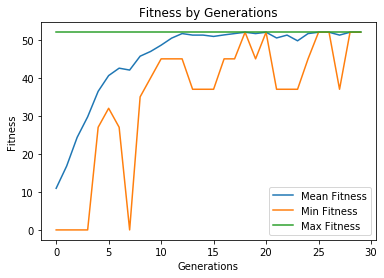

Average of fitness  of last gen: 52.0


In [7]:
GA_standard = Genetic_Algorithm(print_details = True)
GA_standard.adaption()

# Results of 1000 GA Simulations (30 Generations)

In [8]:
simulation_results = [] 
for x in range(1000):
    GA_standard = Genetic_Algorithm(print_details = False)
    GA_standard.adaption()
    simulation_results.append(GA_standard.fitness_avg_history[len(GA_standard.fitness_avg_history)-1])
print("Generations = 30 , Average of fitness 1000 Simulations: ",sum(simulation_results)/len(simulation_results))

Generations = 30 , Average of fitness 1000 Simulations:  46.37730000000017


# Results of 1000 GA Simulations (40 Generations)

In [9]:
simulation_results = [] 
for x in range(1000):
    GA_40_generations = Genetic_Algorithm(print_details = False,number_of_generations=40)
    GA_40_generations.adaption()
    simulation_results.append(GA_40_generations.fitness_avg_history[len(GA_40_generations.fitness_avg_history)-1])
print("Generations = 40 , Average of fitness 1000 Simulations: ",sum(simulation_results)/len(simulation_results))

Generations = 40 , Average of fitness 1000 Simulations:  46.78650000000021


# Results of 1000 GA Simulations (50 Generations)

In [10]:
simulation_results = [] 
for x in range(1000):
    GA_50_generations = Genetic_Algorithm(print_details = False,number_of_generations=50)
    GA_50_generations.adaption()
    simulation_results.append(GA_50_generations.fitness_avg_history[len(GA_50_generations.fitness_avg_history)-1])
print("Generations = 50 , Average of fitness 1000 Simulations: ",sum(simulation_results)/len(simulation_results))

Generations = 50 , Average of fitness 1000 Simulations:  46.39855000000017


# Results of 1000 GA Simulations (60 Generations)

In [ ]:
simulation_results = [] 
for x in range(1000):
    GA_60_generations = Genetic_Algorithm(print_details = False,number_of_generations=60)
    GA_60_generations.adaption()
    simulation_results.append(GA_60_generations.fitness_avg_history[len(GA_60_generations.fitness_avg_history)-1])
print("Generations = 60 , Average of fitness 1000 Simulations: ",sum(simulation_results)/len(simulation_results))

# Results of 1000 GA Simulations (100 Generations)

In [ ]:
simulation_results = [] 
for x in range(1000):
    GA_100_generations = Genetic_Algorithm(print_details = False,number_of_generations=100)
    GA_100_generations.adaption()
    simulation_results.append(GA_100_generations.fitness_avg_history[len(GA_100_generations.fitness_avg_history)-1])
print("Generations = 100 , Average of fitness 1000 Simulations: ",sum(simulation_results)/len(simulation_results))